# Possion Equation

\begin{equation}
    \left\{
    \begin{aligned}
        &-\frac{\partial^2u}{\partial x^2}(x) = f(x) \qquad x\in \Omega=(0,\frac{3}{2})\\
        &u(x)=g(x)\qquad x\in \partial \Omega
    \end{aligned}
    \right.
\end{equation}
We construct the equation by the real solution $u(x)=xcos(\omega x)$, having corresponding source term $f(x)$ and boundary condition $g(x)$. We use DGNet to approximate the target function. We can test $w=3\pi$ or $15\pi$

## DGNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
from math import pi
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter
from utilities import *
from problems import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Test about the hyperparameters: $N_{int}, N_x, deg$

In [2]:
# N_int_values = [5, 10, 15, 20, 25, 30]
# N_x_values = [2, 5, 10, 30, 100, 1000, 10000]
# N_deg = [3, 5, 10, 20, 40]

## Nint, N_X
# losses = np.zeros((len(N_int_values), len(N_x_values)))
# for i, N_int in enumerate(N_int_values):
#     for j, N_x in enumerate(N_x_values):
#         P = Poisson1D_dg(N_x=N_x, N_int=N_int, deg=5)
#         losses[i, j] = P.exact_loss()
# plt.figure(figsize=(8, 6))
# im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')
# plt.colorbar(im, label='log(loss)')
# plt.xticks(range(len(N_x_values)), labels=[f"{n}" for n in N_x_values])
# plt.yticks(range(len(N_int_values)), labels=[f"{n}" for n in N_int_values])
# plt.xlabel(r'Number of intervals $N$')
# plt.ylabel(r'Number of integration points $N_{int}$')
# plt.title('Exact Loss as a Function of $N$ and $N_{int}$')
# plt.show()

## N_int, deg
# losses = np.zeros((len(N_deg), len(N_x_values)))
# for i, deg in enumerate(N_deg):
#     for j, N_x in enumerate(N_x_values):
#         P = Poisson1D_dg(N_x=N_x, N_int=15, deg=deg)
#         losses[i, j] = P.exact_loss()

# plt.figure(figsize=(8, 6))
# im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')
# plt.colorbar(im, label='log(loss)')
# plt.xticks(range(len(N_x_values)), labels=[f"{n}" for n in N_x_values])
# plt.yticks(range(len(N_deg)), labels=[f"{n}" for n in N_deg])
# plt.xlabel(r'Number of intervals $N$')
# plt.ylabel(r'Order of test function $p$')
# plt.title('Exact Loss as a Function of $N_{x}$ and $p$')
# plt.show()


In [2]:
P = Poisson1D_dg(N_x=25, N_int=20, deg=5)
# retrain = True
retrain = False
if retrain:
    P.load()
    P.train()
elif P.load() and not retrain:
    print("train loss: ", P.loss())

Loading saved model...


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


train loss:  (tensor(5542.5065, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>), tensor(3.2942, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>), tensor(3.4807, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>))


In [40]:
print(P.loss())

(tensor(1.0891e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>), tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>), tensor(2.3288e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>))


No saved model found. Training the model...
(tensor(1.0891e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>), tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>), tensor(2.3288e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)) tensor(1.2225e-26, device='cuda:0', dtype=torch.float64)


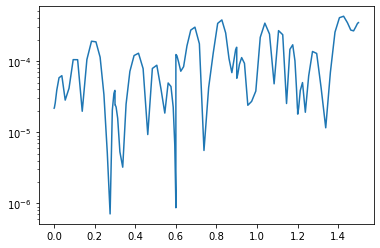

In [41]:
path = f'./models/{P.name}.pth'
if os.path.exists(path):
    print("Loading saved model...")
    model_dict = torch.load(path)
    P.model.load_state_dict(model_dict)
else:
    print("No saved model found. Training the model...")
print(P.loss(), P.exact_loss())
x = P.Mesh
y = P.model(x[..., None])
y = y.cpu().detach().numpy().flatten()
y_exact = P.exact(x)
x = x.cpu().detach().numpy().flatten()
y_exact = y_exact.cpu().detach().numpy().flatten()
err = abs(y-y_exact)
np.savetxt("DGerror.csv", np.column_stack((x, err)), delimiter=",", header="x,err", comments='')

# plt.plot(x, y)
# plt.plot(x, y_exact)
plt.plot(x,err)
plt.yscale('log')
plt.show()

## Here we do the baselines: PINN, DeepRitz, and hpVPINN

### train

In [44]:
P = Poisson1D_base(method='PINN', N_x=10000, N_int=30, num_layers=3, hidden_size=40, deg=3, act='tanh')
P.train()

*********** Started training ...... ***************


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 100: Loss = 3198.596680, mse = 0.336915, mae = 1.161096
Epoch 200: Loss = 3192.238281, mse = 0.350054, mae = 1.217431
Epoch 300: Loss = 3178.068848, mse = 0.389990, mae = 1.233157
Epoch 400: Loss = 3115.321533, mse = 0.450762, mae = 1.262747
Epoch 500: Loss = 2567.757080, mse = 0.669282, mae = 1.855464
Epoch 600: Loss = 1452.561401, mse = 1.174881, mae = 2.725711
Epoch 700: Loss = 1006.730469, mse = 2.643869, mae = 3.043758
Epoch 800: Loss = 877.860657, mse = 2.172504, mae = 2.638177
Epoch 900: Loss = 758.327698, mse = 1.192717, mae = 1.925867
Epoch 1000: Loss = 573.936096, mse = 0.989134, mae = 1.554832
Epoch 1100: Loss = 387.706665, mse = 1.461722, mae = 2.115750
Epoch 1200: Loss = 326.449921, mse = 1.937840, mae = 2.402537
Epoch 1300: Loss = 307.234375, mse = 2.143224, mae = 2.496244
Epoch 1400: Loss = 295.927002, mse = 2.208135, mae = 2.519856
Epoch 1500: Loss = 287.557892, mse = 2.202304, mae = 2.513197
Epoch 1600: Loss = 280.023224, mse = 2.177246, mae = 2.498209
Epoch 1700

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10654/3673320067.py", line 2, in <cell line: 2>
    P.train()
  File "/tmp/ipykernel_10654/1755049000.py", line 132, in train
    loss, mae, mse = self.loss()
  File "/tmp/ipykernel_10654/1755049000.py", line 68, in loss
    return self.pinn()
  File "/tmp/ipykernel_10654/1755049000.py", line 78, in pinn
    u = self.model(self.mesh)
  File "/root/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/data/update_dg/zzzupdate/utilities.py", line 276, in forward
    x = self.activation(layer(x))
  File "/root/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/root/anaconda3/lib/python3.9

### load

Loading saved model...
(tensor(-25.3696, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.0282, device='cuda:0', grad_fn=<MaxBackward1>), tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>))


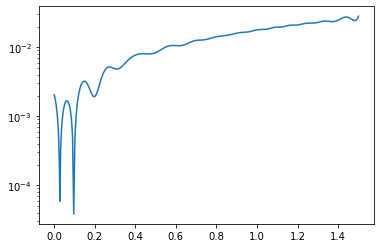

In [20]:
# P = Poisson1D(method='DeepRitz', N_x=200, N_int=20, num_layers=6, hidden_size=40, deg=3, act='tanh')
# P = Poisson1D(method='PINN', N_x=10000, N_int=20, num_layers=6, hidden_size=40, deg=3, act='tanh')
P.load()
print(P.loss())
x = P.mesh
y = P.model(x[..., None])
y = y.cpu().detach().numpy().flatten()
y_exact = P.exact(x)
x = x.cpu().detach().numpy().flatten()
y_exact = y_exact.cpu().detach().numpy().flatten()
err = abs(y-y_exact)
np.savetxt(f"./{P.method}_error.csv", np.column_stack((x, err)), delimiter=",", header="x,err", comments='')

plt.plot(x,err)
# plt.plot(x, y)
# plt.plot(x, y_exact)
plt.yscale('log')
plt.show()